In [89]:
# PATHS TO FILES


import numpy as np
import pandas as pd
import xpress as xp
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import ast

# Define the base path explicitly to where your files are stored
# This is the correct path on your machine
base_path = '/Users/sydneytrilling/Desktop/Grad School Assignments/MMC/Final Project/data'

# Read in files using the explicitly defined base path
ch_0_conversion_rates = pd.read_csv(os.path.join(base_path, 'channel_0_conversion_rates.csv'))
ch_0_schedule = pd.read_csv(os.path.join(base_path, 'channel_0_schedule.csv'))
ch_1_conversion_rates = pd.read_csv(os.path.join(base_path, 'channel_1_conversion_rates.csv'))
ch_1_schedule = pd.read_csv(os.path.join(base_path, 'channel_1_schedule.csv'))
ch_2_conversion_rates = pd.read_csv(os.path.join(base_path, 'channel_2_conversion_rates.csv'))
ch_2_schedule = pd.read_csv(os.path.join(base_path, 'channel_2_schedule.csv'))
ch_A_schedule = pd.read_csv(os.path.join(base_path, 'channel_A_schedule.csv'))
movies_df = pd.read_csv(os.path.join(base_path, 'movie_database.csv'))

In [90]:
# FORMATING
# Convert 'Date-Time' columns to datetime format
date_cols = ['Date']

for df in [ch_0_conversion_rates, ch_0_schedule, ch_1_conversion_rates, ch_1_schedule,
           ch_2_conversion_rates, ch_2_schedule, ch_A_schedule]:
    df['Date'] = pd.to_datetime(df['Date'])

# Convert 'Release Date' in movie_database to datetime
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])

# Fill missing values if necessary
movies_df.fillna(0, inplace=True)


In [91]:
# Make 30-min slots
# Slot duration 30 minutes
slot_duration = 30  # minutes
slots_needed = (movies_df['runtime_with_ads'] / slot_duration).apply(lambda x: int(x)).astype(int)
movies_df['slots_needed'] = slots_needed


In [92]:
# To use right xpress and get rid of unnecessary error codes
xp.init('C:/xpressmp/bin/xpauth.xpr')
pd.options.mode.copy_on_write = True

InterfaceError: Xpress licensing error 1: The license file was not found at 'C:/xpressmp/bin/xpauth.xpr'. Please ensure you have installed it according to the instructions in the FICO Xpress READMEs.

In [93]:
# Check for duplicate movie titles
duplicate_titles = movies_df[movies_df.duplicated(subset=['title'], keep=False)]
if not duplicate_titles.empty:
    print("Duplicate movie titles found:")
    print(duplicate_titles['title'])
else:
    print("No duplicate movie titles found.")

Duplicate movie titles found:
4                 The Avengers
17                     Titanic
76               The Lion King
105       Beauty and the Beast
149        Alice in Wonderland
                 ...          
5748              Midnight Sun
5761                The Island
5773            The Shaggy Dog
5855    Fun with Dick and Jane
5879        The Perfect Weapon
Name: title, Length: 258, dtype: object


                 scaled_popularity  children_scaled_popularity  adults_scaled_popularity  retirees_scaled_popularity
genres                                                                                                              
Animation                 0.627061                    0.597353                  0.414116                    0.364228
Fantasy                   0.578887                    0.516281                  0.523282                    0.326327
Adventure                 0.565739                    0.487587                  0.505442                    0.304907
Action                    0.543748                    0.421140                  0.527781                    0.303277
Science Fiction           0.542932                    0.363374                  0.529115                    0.270816
Family                    0.533974                    0.497997                  0.381827                    0.353664
Horror                    0.496980                    0.244998  

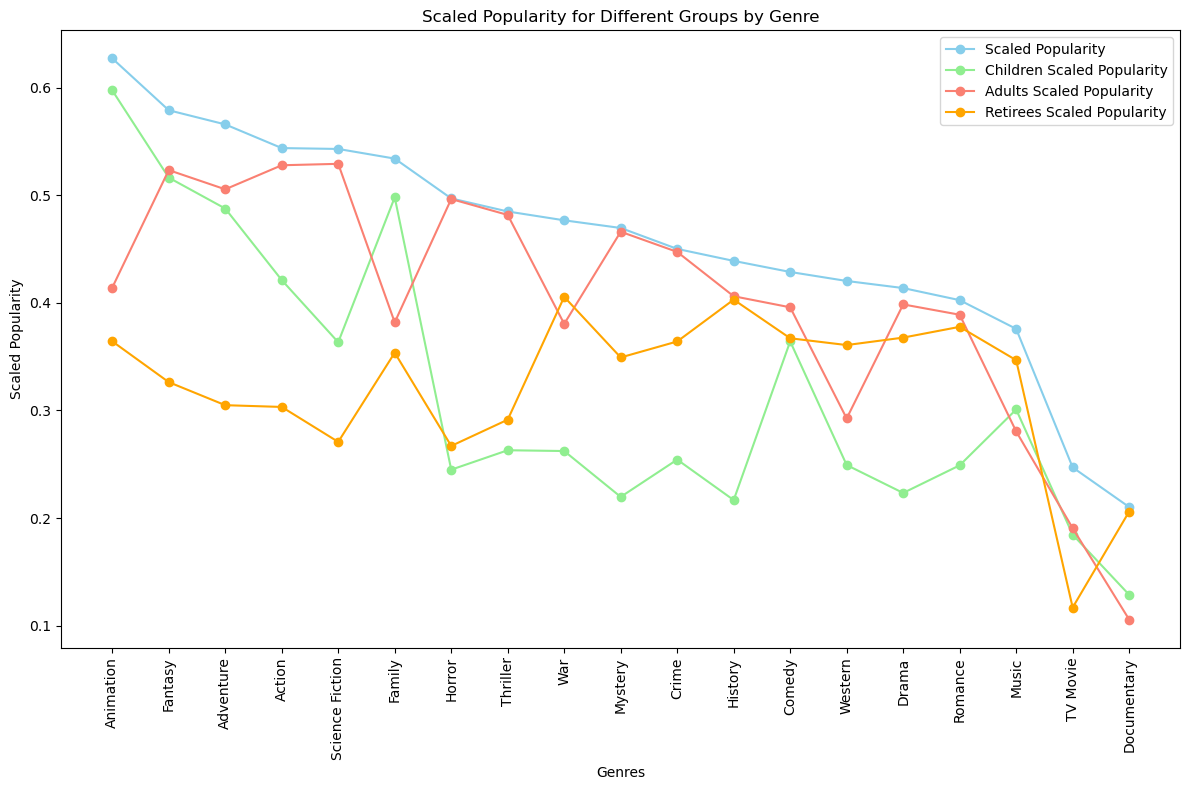

In [94]:

movies_df['genres'] = movies_df['genres'].apply(
    lambda x: x.strip("[]").replace("'", "").split(', ') if isinstance(x, str) else x
)
genre = movies_df['genres']

movies_df_exploded = movies_df.explode('genres', ignore_index=True)



popularity_ann = movies_df_exploded.loc[:, ['genres','scaled_popularity','children_scaled_popularity','adults_scaled_popularity','retirees_scaled_popularity']]

# Group by the 'genres' column and calculate the mean for the popularity columns
genre_popularity_avg = movies_df_exploded.groupby('genres')[['scaled_popularity',
                                                            'children_scaled_popularity',
                                                            'adults_scaled_popularity',
                                                            'retirees_scaled_popularity']].mean()

# Print the result

# Sort by 'scaled_popularity' if needed
genre_popularity_avg_sorted = genre_popularity_avg.sort_values(by='scaled_popularity', ascending=False)

# Print the resulting table
print(genre_popularity_avg_sorted.to_string())


plt.figure(figsize=(12, 8))  # Set the figure size

# Plot each popularity metric as a separate line
plt.plot(genre_popularity_avg_sorted.index, genre_popularity_avg_sorted['scaled_popularity'], label='Scaled Popularity', marker='o', linestyle='-', color='skyblue')
plt.plot(genre_popularity_avg_sorted.index, genre_popularity_avg_sorted['children_scaled_popularity'], label='Children Scaled Popularity', marker='o', linestyle='-', color='lightgreen')
plt.plot(genre_popularity_avg_sorted.index, genre_popularity_avg_sorted['adults_scaled_popularity'], label='Adults Scaled Popularity', marker='o', linestyle='-', color='salmon')
plt.plot(genre_popularity_avg_sorted.index, genre_popularity_avg_sorted['retirees_scaled_popularity'], label='Retirees Scaled Popularity', marker='o', linestyle='-', color='orange')

# Add labels and title
plt.xlabel('Genres')
plt.ylabel('Scaled Popularity')
plt.title('Scaled Popularity for Different Groups by Genre')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [95]:
# Make broadcast date for any number of days

# Choose the number of days you're make a schedule for 
    # this can  be used in the functions later
num_days = 7

# Define the broadcasting start and end dates
broadcast_start_date = datetime.strptime("2024-10-01", "%Y-%m-%d")
broadcast_end_date = broadcast_start_date + timedelta(days=num_days)  # 7 days including start date

# Define daily broadcast start and end times
daily_broadcast_start_time = timedelta(hours=7, minutes=0)
daily_broadcast_end_time = timedelta(hours=23, minutes=30)

# Generate all time slots over the date range
time_slots = []
current_date = broadcast_start_date
while current_date <= broadcast_end_date:
    # Set the start and end times for the current day
    day_start = datetime.combine(current_date.date(), datetime.min.time()) + daily_broadcast_start_time
    day_end = datetime.combine(current_date.date(), datetime.min.time()) + daily_broadcast_end_time

    current_time = day_start
    while current_time <= day_end:
        time_slots.append(current_time)
        current_time += timedelta(minutes=slot_duration)

    # Move to the next day
    current_date += timedelta(days=1)

# Create mappings between time slots and indices
time_to_index = {t: idx for idx, t in enumerate(time_slots)}
index_to_time = {idx: t for idx, t in enumerate(time_slots)}


In [96]:
# Get the list of movies scheduled on other channels within the last 14 days
def get_movies_shown_on_other_channels(ch_0_schedule, ch_1_schedule, ch_2_schedule):
    # Combine all schedules from the three channels
    combined_schedule = pd.concat([ch_0_schedule, ch_1_schedule, ch_2_schedule])
    
    # Filter out the movies aired in the last 14 days
    today = pd.to_datetime('today')
    past_14_days = today - timedelta(days=14)
    
    # Filter for movies that aired within the last 14 days
    aired_movies = combined_schedule[combined_schedule['Date'] >= past_14_days]
    
    # Get the list of movie titles aired in the last 14 days
    aired_movie_titles = aired_movies['content'].unique()
    
    return aired_movie_titles


In [97]:
# Make a smaller movies dataframe so it doesn't take so long
movies_small = movies_df.head(300)
movies_small.set_index('title', inplace = True)



In [98]:
# Scheduling Optimizer Model
def model(T, movies,aired_movie_title):
    prob = xp.problem(name="Movie_Scheduling_Problem")
    # M = range(len(movies_small))
    # Decision Variables
    # if movie m in shown in time slot t
    x = {(m,t): xp.var(vartype=xp.binary, name='x{0}_{1}'.format(m,t)) 
         for t in T for m in movies.index}
    prob.addVariable(x)
    
    y = {(m): xp.var(vartype=xp.binary, name='y{0}'.format(m)) for m in movies.index}
    prob.addVariable(y)

    # start time of movie m 
    s = {(m): xp.var(vartype=xp.integer, name='s{0}'.format(m)) for m in movies.index}
    prob.addVariable(s)

    # end time of movie m 
    e = {(m): xp.var(vartype=xp.integer, name='e{0}'.format(m)) for m in movies.index}
    prob.addVariable(e)
    decision_vars = [x,y,s,e]
    

    # Constraints
    # for t in T:
        # big M 
    M = len(time_slots)
    T_end = len(time_slots) -1 # last time slot index
    
    # movie duration 
    prob.addConstraint(xp.Sum(x[m,t] for t in T) == movies.loc[m, 'slots_needed']*y[m] for m in movies.index)
  
    # has to be a movie in every slot
    prob.addConstraint(xp.Sum(x[m,t] for m in movies.index) == 1 for t in T)

    # end time
    # prob.addConstraint(e[m] == t*xp.Sum(x) for m in movie.index())

    # end time limit
    prob.addConstraint((t+1)*x[m,t] <= e[m] for m in movies.index for t in T)

    # start time limit
    #prob.addConstraint(s[m] <= (t*x[m,t]) for m in movie.index() fot t in T)

    # latest time a movie can start and still show full movie 
    prob.addConstraint(s[m] <= t*x[m,t] + (1-x[m,t])*M for m in movies.index for t in T)

    # end-start = movie duration
    prob.addConstraint(e[m]-s[m] == movies.loc[m, 'slots_needed']*y[m] for m in movies.index)

    # last movie time?
    prob.addConstraint(s[m] + movies.loc[m, 'slots_needed'] -1 <= T_end for m in movies.index)

    # 14-Day Constraint: Prevent movies shown in the last 14 days from being scheduled again
    for m in movies.index:
        if m in aired_movie_titles:
            for t in T:
                prob.addConstraint(x[m, t] == 0)  # Prevent scheduling this movie on the given channel


    return prob, decision_vars

In [108]:
# Making schedule layout
def get_time(slot_index):
    return time_slots[slot_index].time()

used_movie_ids = []
def get_sched(prob, movies, decision_vars): 
    target_genres = {'Animation', 'Fantasy', 'Adventure', 'Action', 'Science Fiction', 'Family'}
    
    x = decision_vars[0]
    y = decision_vars[1]
    s = decision_vars[2]
    e = decision_vars[3]
    
    scheduled_movies = []
    used_movie_ids = []

    for m in movies_small.index:
    # Retrieve the solution value for y[m_idx]
        y_value = prob.getSolution(y[m])
        
        if y_value > 0.5:  # Movie is scheduled
            used_movie_ids.append(m)
            
            # # Retrieve solution values for s[m_idx] and e[m_idx]
            start_slot = int(prob.getSolution(s[m]))
            end_slot = int(prob.getSolution(e[m]))
            
            # # # # Convert slot indices to actual times
            start_time = get_time(start_slot)
            end_time = get_time(end_slot)

            # Check if the movie is scheduled in the restricted time window (18:00 - 22:00)
            if start_time >= datetime.strptime("18:00", "%H:%M").time() and start_time <= datetime.strptime("22:00", "%H:%M").time():
                movie_genre = movies.loc[m, 'genres']
                
                if isinstance(movie_genre, list):  # If genres are stored as a list
                    if not any(genre in target_genres for genre in movie_genre):
                        continue  # Skip this movie if no allowed genre is found

            # # Append the scheduled movie details
            scheduled_movies.append({
                'Movie Title': m,
                'Start Slot': start_slot,
                'Start Time': start_time.strftime('%H:%M'),
                'End Slot': end_slot,
                'End Time': end_time.strftime('%H:%M')
            })
    schedule_df = pd.DataFrame.from_dict(scheduled_movies)
    schedule_df.sort_values(['Start Slot'], axis = 0, inplace = True)
    print(schedule_df)
    return scheduled_movies, used_movie_ids

In [109]:
# Putting it all together

def movie_sched(number_days):
    total_schedule = []
    scheduled_dates = {}  # Dictionary to track when movies were scheduled by movie_id
    
    # Get the list of movies that have been aired on other channels in the last 14 days
    aired_movie_titles = get_movies_shown_on_other_channels(ch_0_schedule, ch_1_schedule, ch_2_schedule)
    
    for k in range(number_days): 
        # Before each day's scheduling, check for movies that have passed the 7-day window
        eligible_movies = []
        for m, dates in scheduled_dates.items():
            # Check if the movie was scheduled more than 14 days ago
            last_scheduled_date = pd.to_datetime(dates[-1])  # Get the last scheduled date
            if (pd.to_datetime('today') - last_scheduled_date).days > 14:
                eligible_movies.append(m)  # Movie can be scheduled again

        
        if k == 0:
            T = range(0, (k+1)*33)

            prob, decision_vars =  model(T,movies_small,aired_movie_titles)
            
            prob.solve()
            
            scheduled_movies, used_movie_ids = get_sched(prob,movies_small,decision_vars)
            
         # Apply the 14-day constraint here
            valid_scheduled_movies = []
            valid_used_movie_ids = []
            
            for m, movie in zip(used_movie_ids, scheduled_movies):
                movie_date = movie['Start Time']
                # Check if this movie has been scheduled in the last 14 days
                if m not in scheduled_dates:
                    scheduled_dates[m] = []
                
                # Filter out movies scheduled in the past 14 days
                if all((pd.to_datetime(movie_date) - pd.to_datetime(d)).days > 14 for d in scheduled_dates[m]):
                    scheduled_dates[m].append(movie_date)  # Add the current movie date to the list
                    valid_scheduled_movies.append(movie)
                    valid_used_movie_ids.append(m)
                    
                total_schedule.append(valid_scheduled_movies)
                
        # Applying 14-day constraint for movie rescheduling
        valid_scheduled_movies = []
        for movie in scheduled_movies:
            movie_date = movie['Start Time']
            if movie['content'] not in scheduled_dates:
                scheduled_dates[movie['content']] = []
            if all((pd.to_datetime(movie_date) - pd.to_datetime(d)).days > 14 for d in scheduled_dates[movie['Movie Title']]):
                scheduled_dates[movie['content']].append(movie_date)
                valid_scheduled_movies.append(movie)

        total_schedule.extend(valid_scheduled_movies)
            
        if k > 0:
            T = range(k*34, (k*34)+33)

            prob, decision_vars =  model(T,movies_small)
            
            prob.solve()
            
            scheduled_movies, used_movie_ids = get_sched(prob,movies_small,decision_vars)
            
            for i in used_movie_ids:
                movies_small.drop(i, inplace = True)
            total_schedule.append(scheduled_movies)
            
    return scheduled_movies

In [110]:
days = 7
total_schedule = []

for k in range(num_days): 
    T = range(k*34, (k+1)*34)
    # Get the list of movies that have been aired on other channels in the last 14 days
    aired_movie_titles = get_movies_shown_on_other_channels(ch_0_schedule, ch_1_schedule, ch_2_schedule)

    prob, decision_vars =  model(T,movies_small,aired_movie_titles)
    
    prob.solve()
    
    scheduled_movies, used_movie_ids = get_sched(prob,movies_small,decision_vars)
    
    for i in used_movie_ids:
        movies_small.drop(i, inplace = True)
    total_schedule.append(scheduled_movies)




FICO Xpress v9.4.2, Hyper, solve started 15:17:22, Nov 23, 2024
Heap usage: 11MB (peak 11MB, 7526KB system)
Minimizing MILP Movie_Scheduling_Problem using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
     24224 rows        11100 cols        65590 elements     11100 entities
Presolved problem has:
     15084 rows         7955 cols        44720 elements      7955 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 16MB (peak 23MB, 7526KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  2.72e+02] / [ 3.91e-03,  1.99e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  2.72e+02] / [ 1.00e+00,  2.72e+02]
  Objective      [min,max] : [      0.0,       0.0] / [      0.0,       0.0]
Autoscaling applied standard scaling

Symmetric problem: generators: 209, support set: 7955
 Numbe

/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

 *** Solution found:      .000000   Time:   0.13    Heuristic: e ***
STOPPING - MIPRELSTOP target reached (MIPRELSTOP=0.0001  gap=0).
 *** Search completed ***
Uncrunching matrix
Final MIP objective                   : 0.000000000000000e-01
Final MIP bound                       : 0.000000000000000e-01
  Solution time / primaldual integral :      0.13s/ 99.891474%
  Number of solutions found / nodes   :         1 /         0
  Max primal violation      (abs/rel) :       0.0 /       0.0
  Max integer violation     (abs    ) :       0.0
                Movie Title  Start Slot Start Time  End Slot End Time
3            Doctor Strange          34      07:00        38    09:00
4                 Toy Story          38      09:00        41    10:30
2    Avengers: Infinity War          41      10:30        47    13:30
1              The Avengers          47      13:30        53    16:30
0              Interstellar          53      16:30        60    20:00
5  Avatar: The Way of Water          60 

/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

                                Movie Title  Start Slot Start Time  End Slot  \
4                                      Thor          68      07:00        72   
5                             The Lion King          72      09:00        75   
3                                     Joker          75      10:30        80   
2                                The Matrix          80      13:00        85   
1  Harry Potter and the Philosopher's Stone          85      15:30        91   
0                   Guardians of the Galaxy          97      21:30       102   

  End Time  
4    09:00  
5    10:30  
3    13:00  
2    15:30  
1    18:30  
0    07:00  
FICO Xpress v9.4.2, Hyper, solve started 15:17:23, Nov 23, 2024
Heap usage: 10MB (peak 10MB, 7533KB system)
Minimizing MILP Movie_Scheduling_Problem using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
     22946 rows        1043

/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

                                         Movie Title  Start Slot Start Time  \
4                                         Inside Out         102      07:00   
3                                         Iron Man 3         106      09:00   
2                            Avengers: Age of Ultron         111      11:30   
1                            The Wolf of Wall Street         117      14:30   
0  The Lord of the Rings: The Fellowship of the Ring         129      20:30   

   End Slot End Time  
4       106    09:00  
3       111    11:30  
2       117    14:30  
1       124    18:00  
0       136    07:00  
FICO Xpress v9.4.2, Hyper, solve started 15:17:23, Nov 23, 2024
Heap usage: 10MB (peak 10MB, 7535KB system)
Minimizing MILP Movie_Scheduling_Problem using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
     22520 rows        10212 cols        60574 elements     10212 

/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

                               Movie Title  Start Slot Start Time  End Slot  \
5                                       Up         136      07:00       140   
6                                     Lucy         140      09:00       143   
4  Harry Potter and the Chamber of Secrets         143      10:30       149   
3                   Spider-Man: Homecoming         149      13:30       154   
2                     Inglourious Basterds         154      16:00       160   
1                       Mad Max: Fury Road         160      19:00       165   
0                            Black Panther         165      21:30       170   

  End Time  
5    09:00  
6    10:30  
4    13:30  
3    16:00  
2    19:00  
1    21:30  
0    07:00  
FICO Xpress v9.4.2, Hyper, solve started 15:17:23, Nov 23, 2024
Heap usage: 10MB (peak 10MB, 7537KB system)
Minimizing MILP Movie_Scheduling_Problem using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DE

/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

                                Movie Title  Start Slot Start Time  End Slot  \
5                                 John Wick         170      07:00       174   
4                             The Godfather         174      09:00       181   
3  Harry Potter and the Prisoner of Azkaban         181      12:30       187   
2                             Suicide Squad         187      15:30       192   
1        Captain America: The First Avenger         192      18:00       197   
0     The Lord of the Rings: The Two Towers         197      20:30       204   

  End Time  
5    09:00  
4    12:30  
3    15:30  
2    18:00  
1    20:30  
0    07:00  
FICO Xpress v9.4.2, Hyper, solve started 15:17:24, Nov 23, 2024
Heap usage: 10150KB (peak 10150KB, 7539KB system)
Minimizing MILP Movie_Scheduling_Problem using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
     21597 rows      

/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

      Movie Title  Start Slot Start Time  End Slot End Time
5            Coco         204      07:00       208    09:00
6          WALL·E         208      09:00       212    11:00
4           Se7en         212      11:00       217    13:30
3  Jurassic World         217      13:30       222    16:00
2  Thor: Ragnarok         222      16:00       227    18:30
1   Batman Begins         227      18:30       233    21:30
0      Iron Man 2         233      21:30       238    07:00


/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_small.drop(i, inplace = True)
/var/folders/sv/s9947nq933l1yth6lxmgqm3h0000gn/T/ipykernel_16213/3749541844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [270]:
# Initialize the problem
prob = xp.problem(name="Movie_Scheduling_Problem")


In [271]:
# Create variables x_{mt}
x = {}
for m_idx, m_row in movies_df.iterrows():
    m = m_row['title']
    m_id = f"{m.replace(' ', '_')}_{m_idx}"
    for t in range(len(time_slots)):
        var_name = f"x_{m_id}_{t}"
        x[(m_idx, t)] = xp.var(vartype=xp.binary, name=var_name)
        prob.addVariable(x[(m_idx, t)])

# Create variables y_m
y = {}
for m_idx, m_row in movies_df.iterrows():
    m = m_row['title']
    m_id = f"{m.replace(' ', '_')}_{m_idx}"
    var_name = f"y_{m_id}"
    y[m_idx] = xp.var(vartype=xp.binary, name=var_name)
    prob.addVariable(y[m_idx])

# Create variables s_m
s = {}
for m_idx, m_row in movies_df.iterrows():
    m = m_row['title']
    m_id = f"{m.replace(' ', '_')}_{m_idx}"
    var_name = f"s_{m_id}"
    s[m_idx] = xp.var(vartype=xp.integer, name=var_name, lb=0, ub=len(time_slots)-1)
    prob.addVariable(s[m_idx])

# Create variables e_m
e = {}
for m_idx, m_row in movies_df.iterrows():
    m = m_row['title']
    m_id = f"{m.replace(' ', '_')}_{m_idx}"
    var_name = f"e_{m_id}"
    e[m_idx] = xp.var(vartype=xp.integer, name=var_name, lb=0, ub=len(time_slots)-1)
    prob.addVariable(e[m_idx])


In [272]:
# Map baseline viewership to time slot indices
baseline_viewership = {}
for idx, row in ch_A_schedule_30min.iterrows():
    time_slot_datetime = row['Date']
    # Find the corresponding time slot index
    time_slot_index = time_to_index.get(time_slot_datetime, None)
    if time_slot_index is not None:
        baseline_viewership[time_slot_index] = {
            'children': row['children_baseline_view_count'],
            'adults': row['adults_baseline_view_count'],
            'retirees': row['retirees_baseline_view_count'],
            'prime_time_factor': row.get('prime_time_factor', 1)
        }


NameError: name 'ch_A_schedule_30min' is not defined

In [ ]:
print("Baseline Viewership Data:")
for key, value in list(baseline_viewership.items())[:5]:  # Print first 5 entries
    print(f"Time Slot {key}: {value}")


In [ ]:
# Total population (adjust as needed)
total_population = 1_000_000 

# Compute base viewership
base_viewership = {}
for m_idx, m_row in movies_df.iterrows():
    m = m_row['title']
    m_id = f"{m.replace(' ', '_')}_{m_idx}"
    # Scaled popularity for the movie
    scaled_popularity = {
        'children': m_row['children_scaled_popularity'],
        'adults': m_row['adults_scaled_popularity'],
        'retirees': m_row['retirees_scaled_popularity']
    }
    for t in range(len(time_slots)):
        # Baseline viewership for the time slot
        baseline = baseline_viewership.get(t, {
            'children': 0,
            'adults': 0,
            'retirees': 0,
            'prime_time_factor': 1
        })
        # Calculate base viewership for this movie and time slot
        viewership = 0
        for group in ['children', 'adults', 'retirees']:
            group_viewership = (
                baseline[group] *
                scaled_popularity[group] *
                baseline['prime_time_factor'] *
                total_population
            )
            viewership += group_viewership
        # Store the calculated viewership
        base_viewership[(m_idx, t)] = viewership



In [ ]:
# PRINT EXAMPLE OF BASE VIEWERSHIP. CONTAINS VIEWERSHIP PER MOVIE PER TIME SLOT (sums all groups)
print("Sample of base_viewership:")
sample_items = list(base_viewership.items())[:5]
for key, value in sample_items:
    print(f"{key}: {value}")


In [ ]:
# Create the objective function expression
objective_terms = []
for m_idx, m_row in movies_df.iterrows():
    for t in range(len(time_slots)):
        var = x[(m_idx, t)]
        coeff = base_viewership.get((m_idx, t), 0)
        if coeff != 0:
            objective_terms.append(coeff * var)

# Set the objective function
prob.setObjective(xp.Sum(objective_terms), sense=xp.maximize)


In [ ]:
# Constraint 1: Time Slot Occupancy Constraint
for t in range(len(time_slots)):
    prob.addConstraint(
        xp.Sum(x[(m_idx, t)] for m_idx in movies_df.index) == 1
    )


In [ ]:
# Constraint 2: Movie Duration Constraint
for m_idx, m_row in movies_df.iterrows():
    d_m = m_row['slots_needed']
    duration = xp.Sum(x[(m_idx, t)] for t in range(len(time_slots)))
    prob.addConstraint(duration == y[m_idx] * d_m)


In [ ]:
# Constraint 3: End Time Definition Constraint
for m_idx in movies_df.index:
    for t in range(len(time_slots)):
        end_time_constraint = e[m_idx] >= t * x[(m_idx, t)]
        prob.addConstraint(end_time_constraint)


In [ ]:
# Constraint 4: Movie Duration Relationship Constraint
for m_idx, m_row in movies_df.iterrows():
    d_m = m_row['slots_needed']
    duration_relationship = e[m_idx] - s[m_idx] + 1 == y[m_idx] * d_m
    prob.addConstraint(duration_relationship)


In [ ]:
# Define Big-M
M = len(time_slots)

# Constraint 5: Start Time Constraint
for m_idx in movies_df.index:
    for t in range(len(time_slots)):
        start_time_constraint = s[m_idx] <= t + M * (1 - x[(m_idx, t)])
        prob.addConstraint(start_time_constraint)


In [273]:
# Constraint 6: Contiguity Constraint
for m_idx, m_row in movies_df.iterrows():
    d_m = m_row['slots_needed']
    for t in range(len(time_slots)):
        # Enforce x_{mt} == 1 if t is within [s_m, s_m + d_m -1]
        # Using Big-M constraints
        
        # x_{mt} >= y_m - (s_m > t + d_m -1)
        # Since we cannot use logical operators, use linear constraints
        
        # If t >= s_m and t < s_m + d_m, then x_{mt} >= y_m
        # Otherwise, x_{mt} >= 0 (which is already ensured since x is binary)
        
        # Implement the following:
        # x_{mt} >= y_m + (t - s_m) / M - (t - s_m - d_m + 1) / M - 1
        # This is a linear approximation and may not strictly enforce contiguity
        # Hence, it's better to use integer variables and enforce exact relations
        
        # Instead, we'll use the relationship defined in Constraint 4 to indirectly enforce contiguity
        pass  # Already handled by Constraints 2 and 4


In [274]:
# Constraint 7: Broadcasting Time Limit Constraint
T_end = len(time_slots) - 1  # Last time slot index

for m_idx, m_row in movies_df.iterrows():
    d_m = m_row['slots_needed']
    broadcasting_limit = s[m_idx] + d_m - 1 <= T_end
    prob.addConstraint(broadcasting_limit)


In [275]:
# Set solver options if needed (optional)
# For example, to set the time limit or verbosity
# xp.control.outputlog = 1  # Enable solver output
# xp.control.maxtime = 600  # Set maximum solving time to 600 seconds

# Solve the problem
prob.solve()

# Retrieve the solver status
status = prob.getProbStatus()
print(f"Solver Status: {status}")

FICO Xpress v9.4.2, Hyper, solve started 15:32:07, Nov 20, 2024
Heap usage: 514MB (peak 514MB, 364MB system)
Minimizing MILP Movie_Scheduling_Problem using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
      5920 rows      1628000 cols         5920 elements   1628000 entities
Presolved problem has:
         0 rows            0 cols            0 elements         0 entities
Presolve finished in 0 seconds
Heap usage: 679MB (peak 1170MB, 364MB system)
Will try to keep branch and bound tree memory usage below 7.0GB
Starting concurrent solve with dual (1 thread)

 Concurrent-Solve,   0s
            Dual        
    objective   dual inf
 D   .0000000   .0000000
                        
------- optimal --------
Concurrent statistics:
           Dual: 0 simplex iterations, 0.00s
Optimal solution found
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0  

In [258]:
# Function to convert time slot index to actual time
def get_time(slot_index):
    return time_slots[slot_index].time()

# Initialize a list to store scheduled movies
scheduled_movies = []

for m_idx, m_row in movies_df.iterrows():
    # Retrieve the solution value for y[m_idx]
    y_value = prob.getSolution(y[m_idx])
    
    if y_value > 0.5:  # Movie is scheduled
        # Retrieve solution values for s[m_idx] and e[m_idx]
        start_slot = int(prob.getSolution(s[m_idx]))
        end_slot = int(prob.getSolution(e[m_idx]))
        
        # Convert slot indices to actual times
        start_time = get_time(start_slot)
        end_time = get_time(end_slot)
        
        # Append the scheduled movie details
        scheduled_movies.append({
            'Movie Index': m_idx,
            'Movie Title': m_row['title'],
            'Start Slot': start_slot,
            'Start Time': start_time.strftime('%H:%M'),
            'End Slot': end_slot,
            'End Time': end_time.strftime('%H:%M')
        })

# Convert to DataFrame for better visualization
schedule_df = pd.DataFrame(scheduled_movies)

print("Scheduled Movies:")
print(schedule_df)


KeyboardInterrupt: 

In [ ]:
# Initialize a list to store time slot assignments
time_slot_assignments = []

for t in range(len(time_slots)):
    for m_idx in movies_df.index:
        if prob.getSolution(x[(m_idx, t)]) > 0.5:
            movie_title = movies_df.loc[m_idx, 'title']
            start_slot = int(prob.getSolution(s[m_idx]))
            start_time = get_time(start_slot)
            end_slot = int(prob.getSolution(e[m_idx]))
            end_time = get_time(end_slot)
            time_slot_assignments.append({
                'Time Slot Index': t,
                'Time': time_slots[t].strftime('%H:%M'),
                'Movie Title': movie_title,
                'Start Time': start_time.strftime('%H:%M'),
                'End Time': end_time.strftime('%H:%M')
            })
            break  # Since only one movie per time slot

# Convert to DataFrame
schedule_mapping_df = pd.DataFrame(time_slot_assignments)

